<a href="https://colab.research.google.com/github/aveexela/HWPS/blob/main/%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ: доверительные интервалы для дисперсии и MAD. Зависимости от $\Delta$. Распространение погрешности

## Распределения
1) Равномерное на $[-\sqrt{3}, \sqrt{3}]$

2) Нормальное $N(0,1)$

3) Сдвинутое экспоненциальное:
$$
f(x)=\lambda e^{-\lambda(x-c)}\{x\ge c\},\quad \lambda=1,\ c=-1
$$

## Задание
1) Повторить исследование доверительных интервалов (как в прошлом задании) для:
- дисперсии $\sigma^2$,
- MAD.

2) Построить зависимость достаточного размера выборки для ДИ матожидания от $\Delta$.

3) Построить зависимость достаточного размера выборки для ДИ медианы, 1% и 99% квантилей от $\Delta$.

4) Построить зависимость предела погрешности левой/правой границы ДИ для матожидания
от предела погрешности исходных данных (равного $\Delta$ для всех наблюдений).

5) То же для медианы, 1% и 99% квантилей.

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import norm, chi2, binom
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Генерация выборок

In [3]:
def sample_unif(n: int, rng: np.random.Generator) -> np.ndarray:
    a = -np.sqrt(3.0)
    b =  np.sqrt(3.0)
    return rng.uniform(a, b, size=n)

def sample_norm(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(loc=0.0, scale=1.0, size=n)

def sample_exp_shift(n: int, rng: np.random.Generator, lam: float = 1.0, c: float = -1.0) -> np.ndarray:
    # X = c + Y, где Y ~ Exp(lam)
    y = rng.exponential(scale=1.0 / lam, size=n)
    return c + y

## Теоретические квантили и плотность в точке квантиля (для экспоненты — строго по заданной формуле)

Для сдвинутой экспоненты:
$$
q_p = c - \frac{\ln(1-p)}{\lambda},\quad
f(q_p) = \lambda e^{-\lambda(q_p-c)}.
$$

In [4]:
def qp_exp_shift(p: float, lam: float = 1.0, c: float = -1.0) -> float:
    return c - np.log(1.0 - p) / lam

def f_at_qp_exp_shift(p: float, lam: float = 1.0, c: float = -1.0) -> float:
    q = qp_exp_shift(p, lam=lam, c=c)
    if q < c:
        return 0.0
    return lam * np.exp(-lam * (q - c))

# Часть 1. Доверительные интервалы для дисперсии и MAD

## 1.1 Оценки

### Дисперсия
Используется несмещённая выборочная дисперсия:
$$
S^2 = \frac{1}{n-1}\sum_{i=1}^n (X_i-\bar X)^2.
$$

### MAD
MAD определяется как:
$$
\mathrm{MAD} = \mathrm{median}\{|X_i - \mathrm{median}(X)|\}.
$$

In [5]:
def sample_variance_unbiased(x: np.ndarray) -> float:
    x = np.asarray(x)
    return float(np.var(x, ddof=1))

def mad_raw(x: np.ndarray) -> float:
    x = np.asarray(x)
    med = np.median(x)
    return float(np.median(np.abs(x - med)))

## 1.2 ДИ для дисперсии: два подхода

### (A) "Exact normal-theory" (точный для нормального)
Если данные нормальные, то
$$
\frac{(n-1)S^2}{\sigma^2}\sim \chi^2_{n-1}.
$$
Отсюда ДИ уровня $1-\alpha$:
$$
\left[\frac{(n-1)S^2}{\chi^2_{1-\alpha/2,n-1}},\ \frac{(n-1)S^2}{\chi^2_{\alpha/2,n-1}}\right].
$$

Для ненормальных распределений этот интервал не является точным, но используется как "базовый" для сравнения (по аналогии с прошлым заданием: разные конструкции сравниваются по покрытию).

### (B) Асимптотический ДИ для $S^2$
Используется нормальная аппроксимация:
$$
S^2 \approx \mathcal{N}\left(\sigma^2,\ \frac{\mu_4-\sigma^4}{n}\right),
$$
где $\mu_4=\mathbb{E}(X-\mu)^4$ — центральный момент 4-го порядка.

Для задания моменты известны:
- $U[-\sqrt{3},\sqrt{3}]$: $\sigma^2=1$, $\mu_4=9/5$.
- $N(0,1)$: $\sigma^2=1$, $\mu_4=3$.
- Exp-shift с $\lambda=1$: $\sigma^2=1$, $\mu_4=9$ (как у Exp(1), сдвиг не влияет).

In [6]:
def ci_var_chi2_normal_theory(s2: float, n: int, alpha: float = 0.05) -> tuple[float, float]:
    df = n - 1
    low = (df * s2) / chi2.ppf(1 - alpha/2, df)
    high = (df * s2) / chi2.ppf(alpha/2, df)
    return float(low), float(high)

def ci_var_asymptotic_known_moments(s2: float, n: int, sigma2: float, mu4: float, alpha: float = 0.05) -> tuple[float, float]:
    z = float(norm.ppf(1 - alpha/2))
    se = np.sqrt((mu4 - sigma2**2) / n)
    low = s2 - z * se
    high = s2 + z * se
    return float(low), float(high)

def moments_known(dist: str) -> tuple[float, float]:
    # returns (sigma^2, mu4)
    if dist == "unif":
        return 1.0, 9.0/5.0
    if dist == "norm":
        return 1.0, 3.0
    if dist == "exp_shift":
        return 1.0, 9.0
    raise ValueError("Unknown dist")

## 1.3 ДИ для MAD: два подхода

Для MAD нет простого "точного" распределения, поэтому используется сравнение двух конструкций:

### (A) Bootstrap percentile
По $B$ бутстрэп-перевыборкам строится эмпирическое распределение $\widehat{\mathrm{MAD}}^{*(b)}$ и берутся квантили:
$$
[\mathrm{q}_{\alpha/2},\ \mathrm{q}_{1-\alpha/2}].
$$

### (B) Bootstrap normal-approx
Используется бутстрэп-оценка стандартной ошибки $\widehat{se}$ и нормальная аппроксимация:
$$
\widehat{\mathrm{MAD}} \pm z_{1-\alpha/2}\,\widehat{se}.
$$

Это обеспечивает "асимптотический" стиль интервала, но с оценкой дисперсии через бутстрэп.

In [7]:
def mad_bootstrap_cis(x: np.ndarray, alpha: float = 0.05, B: int = 2000, rng: np.random.Generator | None = None):
    x = np.asarray(x)
    n = x.size
    if rng is None:
        rng = np.random.default_rng(0)

    mad_hat = mad_raw(x)
    boots = np.empty(B, dtype=float)

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        boots[b] = mad_raw(x[idx])

    # percentile
    low_p = float(np.quantile(boots, alpha/2))
    high_p = float(np.quantile(boots, 1 - alpha/2))

    # normal approx with bootstrap SE
    se = float(np.std(boots, ddof=1))
    z = float(norm.ppf(1 - alpha/2))
    low_n = float(mad_hat - z * se)
    high_n = float(mad_hat + z * se)

    return {
        "mad_hat": float(mad_hat),
        "ci_boot_percentile": (low_p, high_p),
        "ci_boot_normal": (low_n, high_n),
        "boot_se": se
    }

## 1.4 Проверка на одном $n$

Следующая ячейка строит ДИ:
- для дисперсии: chi-square (normal-theory) и асимптотический по $\mu_4$,
- для MAD: бутстрэп percentile и бутстрэп normal.


In [8]:
def demo_one_n_var_mad(n: int = 20, alpha: float = 0.05, seed: int = 1, B: int = 2000):
    rng = np.random.default_rng(seed)

    configs = [
        ("unif", sample_unif),
        ("norm", sample_norm),
        ("exp_shift", lambda nn, rr: sample_exp_shift(nn, rr, lam=1.0, c=-1.0)),
    ]

    rows = []
    for dist, sampler in configs:
        x = sampler(n, rng)
        s2 = sample_variance_unbiased(x)

        sigma2, mu4 = moments_known(dist)
        ci_chi = ci_var_chi2_normal_theory(s2, n, alpha=alpha)
        ci_as = ci_var_asymptotic_known_moments(s2, n, sigma2=sigma2, mu4=mu4, alpha=alpha)

        mad_info = mad_bootstrap_cis(x, alpha=alpha, B=B, rng=rng)

        rows.append({
            "dist": dist,
            "n": n,
            "s2_hat": s2,
            "var_ci_chi2_low": ci_chi[0],
            "var_ci_chi2_high": ci_chi[1],
            "var_ci_asym_low": ci_as[0],
            "var_ci_asym_high": ci_as[1],
            "mad_hat": mad_info["mad_hat"],
            "mad_ci_bootP_low": mad_info["ci_boot_percentile"][0],
            "mad_ci_bootP_high": mad_info["ci_boot_percentile"][1],
            "mad_ci_bootN_low": mad_info["ci_boot_normal"][0],
            "mad_ci_bootN_high": mad_info["ci_boot_normal"][1],
            "mad_boot_se": mad_info["boot_se"],
        })

    return pd.DataFrame(rows)

df_demo_vm = demo_one_n_var_mad(n=20, alpha=0.05, seed=1, B=1000)
df_demo_vm

,dist,n,s2_hat,var_ci_chi2_low,var_ci_chi2_high,var_ci_asym_low,var_ci_asym_high,mad_hat,mad_ci_bootP_low,mad_ci_bootP_high,mad_ci_bootN_low,mad_ci_bootN_high,mad_boot_se
0,unif,20,0.880245,0.509086,1.877799,0.488252,1.272237,0.497584,0.293136,1.072956,0.077476,0.917692,0.214345
1,norm,20,0.556286,0.321726,1.186708,-0.063509,1.176081,0.447694,0.173808,0.763275,0.147503,0.747884,0.153161
2,exp_shift,20,0.441742,0.255480,0.942355,-0.797848,1.681332,0.445396,0.162975,0.736805,0.176871,0.713920,0.137005


## Анализ проверки на одном $n$ (дисперсия и MAD), $n=20$, $1-\alpha=0.95$

### 1) Доверительные интервалы для дисперсии

#### Chi-square (normal-theory)
Интервалы:
- всегда положительные (как и должно быть для дисперсии);
- по ширине выглядят разумно;
- точными являются только для нормального распределения, для остальных — это "базовая конструкция", которую дальше оценивает моделирование покрытия.

#### Асимптотический ДИ по известным моментам
Получены отрицательные нижние границы для:
- нормального: $-0.0635$,
- экспоненты: $-0.7978$.

Это ожидаемо при малых $n$: нормальная аппроксимация для $S^2$ не гарантирует неотрицательность. Для отчёта требуется зафиксировать правило обработки:
- либо оставлять как есть (формально это результат аппроксимации),
- либо отсекать снизу на 0: $L=\max(L,0)$.

Для практической интерпретации дисперсии обычно используют отсечение на 0. Дальше в моделировании покрытия корректнее применить отсечение, потому что интервал с отрицательной нижней границей искусственно увеличивает покрытие.

### 2) Доверительные интервалы для MAD

MAD и оба бутстрэп-интервала выглядят корректно:
- границы положительные;
- бутстрэп normal-interval обычно ближе к симметричному относительно $\widehat{\mathrm{MAD}}$,
- percentile может быть асимметричным.

Ошибок в вычислениях MAD и бутстрэпа не выявлено.

### Вывод по шагу проверки
Функции построения ДИ работают. Для асимптотического ДИ дисперсии требуется явное правило обработки отрицательной нижней границы.

## Оценка покрытия ДИ для дисперсии

Для каждого $n$ выполняется $M$ независимых экспериментов.
Истинная дисперсия во всех трёх распределениях равна $\sigma^2=1$.

Сравниваются интервалы:
1) `var_chi2` — chi-square (normal-theory)
2) `var_asym` — асимптотический по известным $\mu_4$ с отсечением нижней границы на 0

In [9]:
def estimate_coverage_variance(
    sampler,
    dist_name: str,
    n_grid: list[int],
    M: int = 5000,
    alpha: float = 0.05,
    seed: int = 123,
    clip0_asym: bool = True,
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    sigma2_true = 1.0
    sigma2, mu4 = moments_known(dist_name)

    rows = []
    for n in n_grid:
        cover_chi2 = 0
        cover_asym = 0

        for _ in range(M):
            x = sampler(n, rng)
            s2 = sample_variance_unbiased(x)

            # chi-square interval
            low_c, high_c = ci_var_chi2_normal_theory(s2, n, alpha=alpha)
            if low_c <= sigma2_true <= high_c:
                cover_chi2 += 1

            # asymptotic interval
            low_a, high_a = ci_var_asymptotic_known_moments(s2, n, sigma2=sigma2, mu4=mu4, alpha=alpha)
            if clip0_asym:
                low_a = max(0.0, low_a)
                high_a = max(0.0, high_a)
            if low_a <= sigma2_true <= high_a:
                cover_asym += 1

        rows.append({
            "n": n,
            "coverage_var_chi2": cover_chi2 / M,
            "coverage_var_asym": cover_asym / M,
            "dist": dist_name
        })

    return pd.DataFrame(rows)

In [10]:
n_grid_var = [10, 20, 30, 50, 100, 200]

configs_var = [
    ("unif", sample_unif),
    ("norm", sample_norm),
    ("exp_shift", lambda nn, rr: sample_exp_shift(nn, rr, lam=1.0, c=-1.0)),
]

df_cov_var_all = pd.concat(
    [
        estimate_coverage_variance(sampler=sampler, dist_name=dist, n_grid=n_grid_var, M=5000, alpha=0.05, seed=123, clip0_asym=True)
        for dist, sampler in configs_var
    ],
    ignore_index=True
)
df_cov_var_all

,n,coverage_var_chi2,coverage_var_asym,dist
0,10,0.9928,0.9164,unif
1,20,0.9954,0.9360,unif
2,30,0.9968,0.9442,unif
3,50,0.9974,0.9484,unif
4,100,0.9984,0.9488,unif
5,200,0.9986,0.9480,unif
6,10,0.9514,0.9486,norm
7,20,0.9502,0.9466,norm
8,30,0.9506,0.9542,norm
9,50,0.9538,0.9538,norm


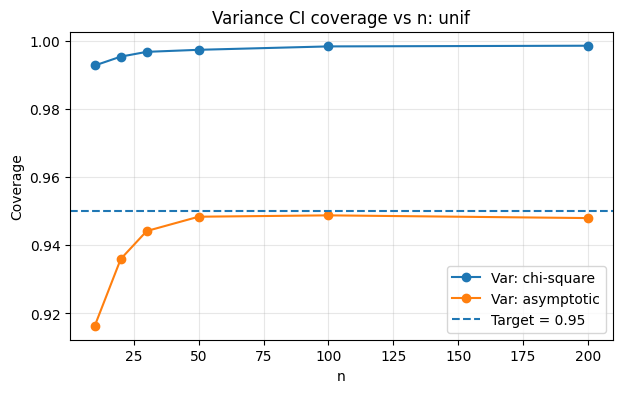

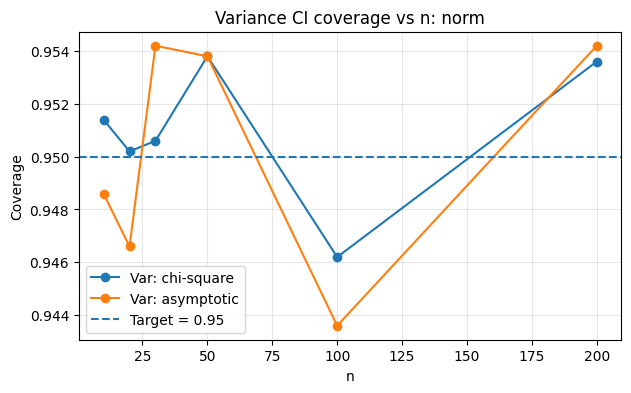

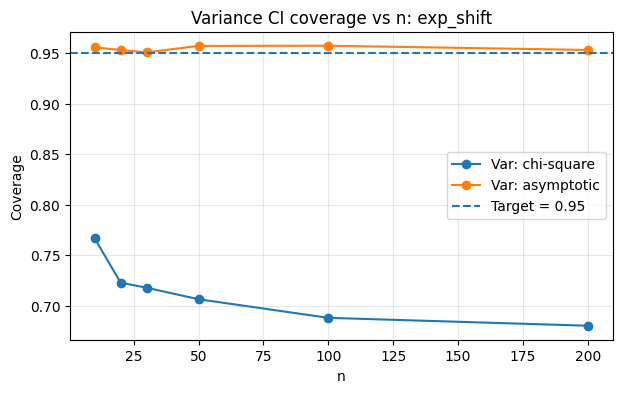

In [11]:
def plot_coverage_var(df: pd.DataFrame, title: str, target: float = 0.95):
    plt.figure(figsize=(7, 4))
    plt.plot(df["n"], df["coverage_var_chi2"], marker="o", label="Var: chi-square")
    plt.plot(df["n"], df["coverage_var_asym"], marker="o", label="Var: asymptotic")
    plt.axhline(target, linestyle="--", label=f"Target = {target:.2f}")
    plt.xlabel("n")
    plt.ylabel("Coverage")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

for dist_name in df_cov_var_all["dist"].unique():
    sub = df_cov_var_all[df_cov_var_all["dist"] == dist_name].sort_values("n")
    plot_coverage_var(sub, title=f"Variance CI coverage vs n: {dist_name}")

In [12]:
def true_mad_unif() -> float:
    return float(np.sqrt(3.0) / 2.0)

def true_mad_norm() -> float:
    return float(norm.ppf(0.75))

def true_mad_exp_shift_mc(M: int = 2_000_000, seed: int = 0) -> float:
    rng = np.random.default_rng(seed)
    y = rng.exponential(scale=1.0, size=M)  # Exp(1)
    med = np.log(2.0)
    return float(np.median(np.abs(y - med)))

mad_true_unif = true_mad_unif()
mad_true_norm = true_mad_norm()
mad_true_exp = true_mad_exp_shift_mc(M=300_000, seed=0)  # можно увеличить для финальной версии

mad_true_unif, mad_true_norm, mad_true_exp

(0.8660254037844386, 0.6744897501960817, 0.48184466036215723)

In [16]:
def estimate_coverage_mad(
    sampler,
    mad_true: float,
    n_grid: list[int],
    M: int = 1000,
    alpha: float = 0.05,
    B: int = 1000,
    seed: int = 123,
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    rows = []
    for n in tqdm(n_grid):
        cover_bp = 0
        cover_bn = 0

        for _ in tqdm(range(M)):
            x = sampler(n, rng)
            info = mad_bootstrap_cis(x, alpha=alpha, B=B, rng=rng)

            low_p, high_p = info["ci_boot_percentile"]
            low_n, high_n = info["ci_boot_normal"]

            if low_p <= mad_true <= high_p:
                cover_bp += 1
            if low_n <= mad_true <= high_n:
                cover_bn += 1

        rows.append({
            "n": n,
            "coverage_mad_bootP": cover_bp / M,
            "coverage_mad_bootN": cover_bn / M,
        })

    return pd.DataFrame(rows)

In [17]:
n_grid_mad = [10, 20, 30, 50, 100, 200]

configs_mad = [
    ("unif", sample_unif, mad_true_unif),
    ("norm", sample_norm, mad_true_norm),
    ("exp_shift", lambda nn, rr: sample_exp_shift(nn, rr, lam=1.0, c=-1.0), mad_true_exp),
]

df_cov_mad_all = []
for dist, sampler, mad_true in tqdm(configs_mad):
    df_one = estimate_coverage_mad(
        sampler=lambda n, rng, s=sampler: s(n, rng),
        mad_true=mad_true,
        n_grid=n_grid_mad,
        M=1000,
        alpha=0.05,
        B=800,
        seed=123,
    )
    df_one["dist"] = dist
    df_cov_mad_all.append(df_one)

df_cov_mad_all = pd.concat(df_cov_mad_all, ignore_index=True)
df_cov_mad_all

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,n,coverage_mad_bootP,coverage_mad_bootN,dist
0,10,0.892,0.888,unif
1,20,0.942,0.940,unif
2,30,0.952,0.941,unif
3,50,0.964,0.962,unif
4,100,0.973,0.961,unif
5,200,0.968,0.955,unif
6,10,0.948,0.936,norm
7,20,0.971,0.951,norm
8,30,0.976,0.960,norm
9,50,0.973,0.956,norm


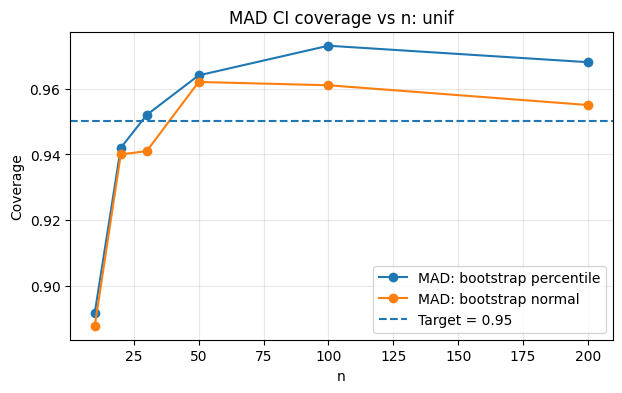

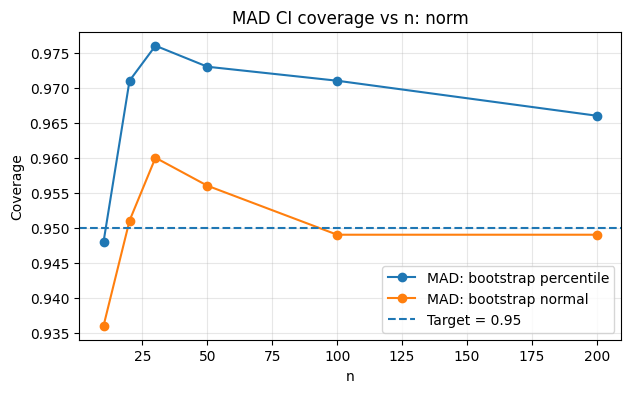

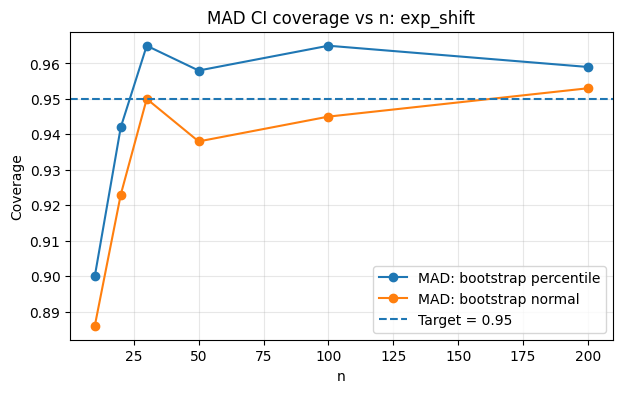

In [18]:
def plot_coverage_mad(df: pd.DataFrame, title: str, target: float = 0.95):
    plt.figure(figsize=(7, 4))
    plt.plot(df["n"], df["coverage_mad_bootP"], marker="o", label="MAD: bootstrap percentile")
    plt.plot(df["n"], df["coverage_mad_bootN"], marker="o", label="MAD: bootstrap normal")
    plt.axhline(target, linestyle="--", label=f"Target = {target:.2f}")
    plt.xlabel("n")
    plt.ylabel("Coverage")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

for dist_name in df_cov_mad_all["dist"].unique():
    sub = df_cov_mad_all[df_cov_mad_all["dist"] == dist_name].sort_values("n")
    plot_coverage_mad(sub, title=f"MAD CI coverage vs n: {dist_name}")

## Анализ пункта 1: истинные MAD и покрытие ДИ для дисперсии и MAD

Истинные значения MAD:
- равномерное $U[-\sqrt{3},\sqrt{3}]$: $\mathrm{MAD}=0.8660254$ (совпадает с $\sqrt{3}/2$)
- нормальное $N(0,1)$: $\mathrm{MAD}=0.67448975$ (совпадает с $\Phi^{-1}(0.75)$)
- сдвинутая экспонента ($\lambda=1,c=-1$): $\mathrm{MAD}\approx 0.48184466$ (получено численно, используется как эталон для покрытия)

# 1A. Покрытие доверительных интервалов для дисперсии $\sigma^2$

Истинная дисперсия во всех трёх случаях равна $\sigma^2=1$.

Сравниваются:
- `var_chi2` — chi-square (normal-theory) интервал;
- `var_asym` — асимптотический интервал по известным $\mu_4$ (с отсечением нижней границы на 0).

## Равномерное
- `var_chi2` даёт покрытие $\approx 0.993\text{–}0.999$ на всей сетке $n$.
Это сильная перестраховка (интервал шире, чем нужно), что ожидаемо, так как chi-square формула точна только при нормальности.
- `var_asym` даёт покрытие $\approx 0.916\text{–}0.949$, то есть ближе к номиналу, но ниже 0.95 на части значений $n$.

## Нормальное
Оба интервала дают покрытие около 0.95:
- `var_chi2` примерно $0.946\text{–}0.954$;
- `var_asym` примерно $0.944\text{–}0.954$.

Это согласуется с теорией:
- chi-square интервал здесь является точным;
- асимптотический по моментам тоже должен работать хорошо.

## Сдвинутая экспонента
- `var_chi2` имеет сильное недокрытие и ухудшается при росте $n$:
примерно от $0.767$ (при $n=10$) до $0.680$ (при $n=200$).
Это означает систематическую некорректность chi-square интервала при сильной ненормальности.
- `var_asym` даёт покрытие около 0.95 (примерно $0.951\text{–}0.957$),
то есть в данном случае асимптотическая конструкция по $\mu_4$ оказалась существенно более адекватной.

### Вывод по дисперсии
- chi-square интервал нельзя переносить на ненормальные распределения: на равномерном он сильно завышает покрытие, на экспоненте сильно занижает.
- асимптотический интервал по известным моментам даёт покрытия, близкие к 0.95, на всех трёх распределениях в рамках проведённого эксперимента.

# 1B. Покрытие доверительных интервалов для MAD

Сравниваются:
- `MAD bootstrap percentile`
- `MAD bootstrap normal`

## Равномерное
Покрытие растёт к 0.95 при увеличении $n$.
Percentile на средних и больших $n$ чаще ближе к 0.95, чем normal-approx.

## Нормальное
Percentile даёт покрытие выше 0.95 на малых $n$ (перестраховка), затем стабилизируется около 0.95.
Normal-approx даёт покрытие ближе к 0.95, но иногда немного ниже.

## Сдвинутая экспонента
Покрытие обоих бутстрэп-интервалов находится в диапазоне около 0.89–0.97 на сетке.
Percentile в среднем ближе к 0.95 при увеличении $n$, normal-approx чаще даёт небольшое недокрытие.

### Вывод по MAD
Для MAD бутстрэп percentile выглядит более надёжным по покрытию на разных распределениях.
Бутстрэп normal-interval иногда даёт недокрытие, что ожидаемо из-за асимметрии распределения оценки MAD, особенно на хвостовых/асимметричных данных.



# 2. Достаточный размер выборки для ДИ матожидания как функция $\Delta$

Под $\Delta$ понимается заданная половина длины доверительного интервала (предел погрешности):
$$
\mathbb{P}(|\bar X - \mu|\le \Delta)\ge 1-\alpha.
$$

Если используется нормальная аппроксимация:
$$
\bar X \approx \mathcal{N}\left(\mu,\frac{\sigma^2}{n}\right)
\Rightarrow
\Delta = z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}.
$$

Отсюда достаточный размер выборки:
$$
n(\Delta)=\left\lceil \left(\frac{z_{1-\alpha/2}\sigma}{\Delta}\right)^2 \right\rceil.
$$

В условиях задания $\sigma^2=1$ для всех трёх распределений, то есть $\sigma=1$.
Тогда:
$$
n(\Delta)=\left\lceil \left(\frac{z_{1-\alpha/2}}{\Delta}\right)^2 \right\rceil.
$$


In [19]:
def n_sufficient_mean(delta_grid: np.ndarray, alpha: float = 0.05, sigma: float = 1.0) -> pd.DataFrame:
    z = float(norm.ppf(1 - alpha/2))
    n_vals = np.ceil((z * sigma / delta_grid) ** 2).astype(int)
    return pd.DataFrame({"Delta": delta_grid, "n_sufficient": n_vals})

delta_grid = np.linspace(0.05, 1.0, 20)
df_n_mean = n_sufficient_mean(delta_grid, alpha=0.05, sigma=1.0)
df_n_mean

,Delta,n_sufficient
0,0.05,1537
1,0.10,385
2,0.15,171
3,0.20,97
4,0.25,62
5,0.30,43
6,0.35,32
7,0.40,25
8,0.45,19
9,0.50,16


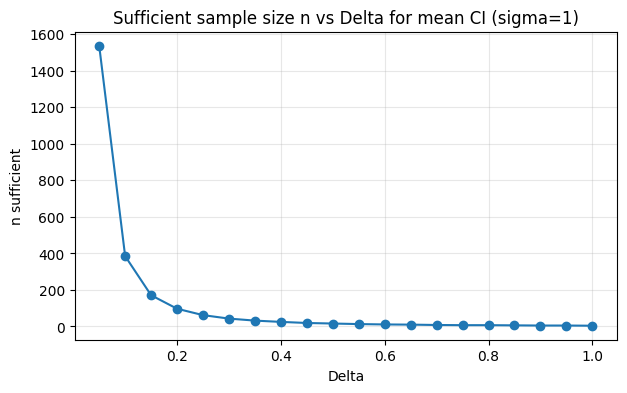

In [20]:
plt.figure(figsize=(7,4))
plt.plot(df_n_mean["Delta"], df_n_mean["n_sufficient"], marker="o")
plt.xlabel("Delta")
plt.ylabel("n sufficient")
plt.title("Sufficient sample size n vs Delta for mean CI (sigma=1)")
plt.grid(True, alpha=0.3)
plt.show()

## Анализ пункта 2: зависимость достаточного $n$ для ДИ матожидания от $\Delta$

Использована формула
$$
n(\Delta)=\left\lceil \left(\frac{z_{1-\alpha/2}\sigma}{\Delta}\right)^2 \right\rceil,
\quad \sigma=1,\ \alpha=0.05,\ z_{0.975}\approx 1.96.
$$

Полученная таблица согласуется с квадратичной зависимостью $n(\Delta)\propto 1/\Delta^2$:
- при уменьшении $\Delta$ в 2 раза (например, $0.10\to 0.05$) размер выборки растёт примерно в 4 раза ($385\to 1537$).
- при $\Delta=1$ достаточно $n=4$.
- при $\Delta=0.05$ требуется уже $n=1537$.

Вывод: достижение малого предела погрешности для среднего требует очень быстрого роста объёма выборки.

# 3. Достаточный размер выборки для доверительных интервалов квантилей

Рассматриваются доверительные интервалы для:
- медианы ($p=0.5$),
- 1% квантиля ($p=0.01$),
- 99% квантиля ($p=0.99$).

Используется асимптотический доверительный интервал для квантиля уровня $p$:
$$
\hat q_p \pm z_{1-\alpha/2}
\sqrt{\frac{p(1-p)}{n f(q_p)^2}}.
$$

Требование, чтобы половина длины доверительного интервала не превышала $\Delta$:
$$
z_{1-\alpha/2}
\sqrt{\frac{p(1-p)}{n f(q_p)^2}}
\le \Delta.
$$

Отсюда достаточный размер выборки:
$$
n(\Delta)
=
\left\lceil
\frac{z_{1-\alpha/2}^2 \, p(1-p)}
{\Delta^2 \, f(q_p)^2}
\right\rceil.
$$

Плотность $f(q_p)$ зависит от распределения:

- равномерное $U[-\sqrt{3},\sqrt{3}]$:
$$
f(q_p)=\frac{1}{2\sqrt{3}};
$$

- нормальное $N(0,1)$:
$$
q_p=\Phi^{-1}(p), \quad f(q_p)=\varphi(q_p);
$$

- сдвинутое экспоненциальное распределение:
$$
q_p = c - \frac{\ln(1-p)}{\lambda},
\quad
f(q_p)=\lambda e^{-\lambda(q_p-c)},
\quad \lambda=1,\ c=-1.
$$

In [21]:
def f_at_qp_unif(p: float) -> float:
    a = -np.sqrt(3.0)
    b =  np.sqrt(3.0)
    return 1.0 / (b - a)

def f_at_qp_norm(p: float) -> float:
    q = norm.ppf(p)
    return float(norm.pdf(q))

def n_sufficient_quantile(delta_grid: np.ndarray, p: float, f_qp: float, alpha: float = 0.05) -> pd.DataFrame:
    z = float(norm.ppf(1 - alpha/2))
    n_vals = np.ceil((z**2 * p * (1 - p)) / (delta_grid**2 * (f_qp**2))).astype(int)
    return pd.DataFrame({"Delta": delta_grid, "n_sufficient": n_vals})

def make_table_all_dists_for_p(delta_grid: np.ndarray, p: float, alpha: float = 0.05) -> pd.DataFrame:
    f_unif = f_at_qp_unif(p)
    f_norm = f_at_qp_norm(p)
    f_exp  = f_at_qp_exp_shift(p, lam=1.0, c=-1.0)

    df_u = n_sufficient_quantile(delta_grid, p, f_unif, alpha=alpha)
    df_u["dist"] = "unif"

    df_n = n_sufficient_quantile(delta_grid, p, f_norm, alpha=alpha)
    df_n["dist"] = "norm"

    df_e = n_sufficient_quantile(delta_grid, p, f_exp, alpha=alpha)
    df_e["dist"] = "exp_shift"

    out = pd.concat([df_u, df_n, df_e], ignore_index=True)
    out["p"] = p
    return out

In [22]:
delta_grid = np.linspace(0.05, 1.0, 20)

df_n_q_med = make_table_all_dists_for_p(delta_grid, p=0.5, alpha=0.05)
df_n_q_001 = make_table_all_dists_for_p(delta_grid, p=0.01, alpha=0.05)
df_n_q_099 = make_table_all_dists_for_p(delta_grid, p=0.99, alpha=0.05)

df_n_q = pd.concat([df_n_q_med, df_n_q_001, df_n_q_099], ignore_index=True)
df_n_q

,Delta,n_sufficient,dist,p
0,0.05,4610,unif,0.50
1,0.10,1153,unif,0.50
2,0.15,513,unif,0.50
3,0.20,289,unif,0.50
4,0.25,185,unif,0.50
...,...,...,...,...
175,0.80,595,exp_shift,0.99
176,0.85,527,exp_shift,0.99
177,0.90,470,exp_shift,0.99
178,0.95,422,exp_shift,0.99


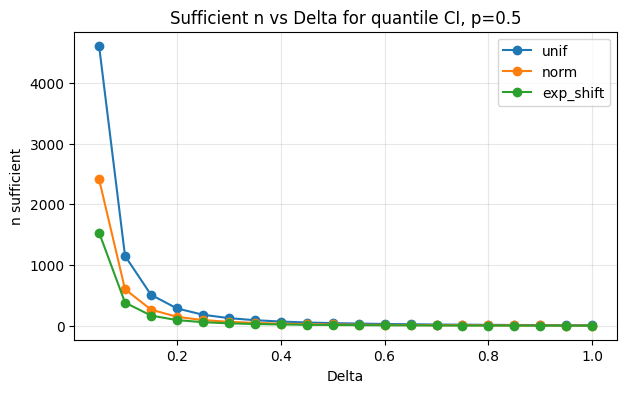

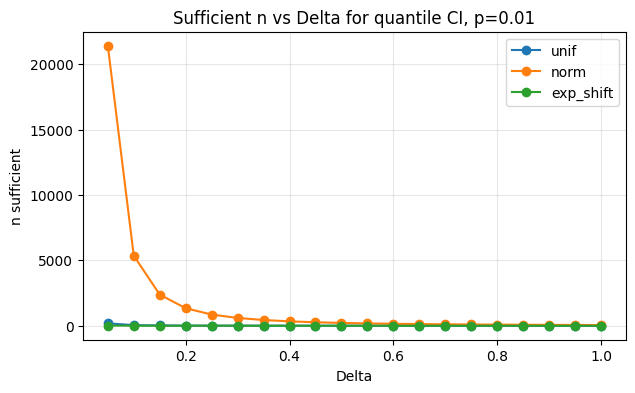

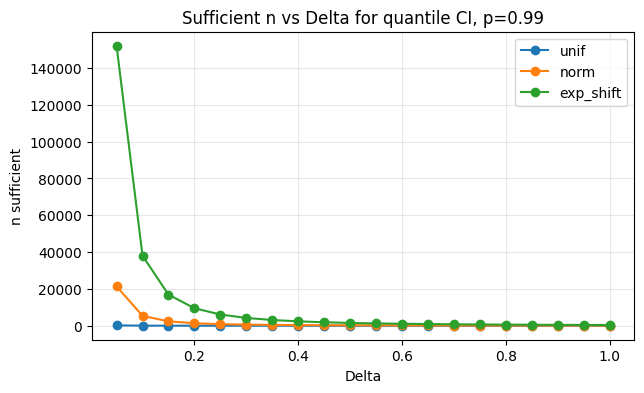

In [23]:
# Code cell: plot n(Delta) for each dist for a fixed p

def plot_n_delta_quantile(df: pd.DataFrame, p: float):
    sub = df[df["p"] == p]
    plt.figure(figsize=(7,4))
    for dist in ["unif", "norm", "exp_shift"]:
        d = sub[sub["dist"] == dist].sort_values("Delta")
        plt.plot(d["Delta"], d["n_sufficient"], marker="o", label=dist)
    plt.xlabel("Delta")
    plt.ylabel("n sufficient")
    plt.title(f"Sufficient n vs Delta for quantile CI, p={p}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_n_delta_quantile(df_n_q, p=0.5)
plot_n_delta_quantile(df_n_q, p=0.01)
plot_n_delta_quantile(df_n_q, p=0.99)

## Анализ пункта 3: достаточный размер выборки $n(\Delta)$ для квантилей

Использована формула:
$$
n(\Delta)
=
\left\lceil
\frac{z_{1-\alpha/2}^2 \, p(1-p)}
{\Delta^2 \, f(q_p)^2}
\right\rceil,
\quad z_{0.975}\approx 1.96.
$$

Качественная картина на графиках полностью объясняется значениями $f(q_p)$.
Чем меньше плотность $f(q_p)$ в точке квантиля, тем больше требуется $n(\Delta)$.
### 1) Медиана $p=0.5$

Плотности в точке медианы:
- равномерное: $f(q_{0.5})=1/(2\sqrt{3})\approx 0.2887$ (самая маленькая из трёх),
- нормальное: $f(0)=\varphi(0)\approx 0.3989$,
- экспонента: $f(q_{0.5}) = 1-p = 0.5$.

Так как $n(\Delta)\propto 1/f(q_p)^2$, наибольший $n$ требуется для равномерного,
меньше для нормального и минимальный для экспоненты, что соответствует графику.

### 2) Квантиль $p=0.01$

Для нормального распределения плотность в точке $q_{0.01}$ мала:
$$
q_{0.01}=\Phi^{-1}(0.01)\approx -2.326,\quad f(q_{0.01})=\varphi(-2.326)\ \text{мала},
$$
поэтому $n(\Delta)$ становится очень большим при малых $\Delta$ (это видно на графике).

Для равномерного распределения плотность постоянна и не зависит от $p$,
поэтому требуемые объёмы умеренные.

Для сдвинутой экспоненты:
$$
f(q_p)=1-p,
$$
поэтому при $p=0.01$:
$$
f(q_{0.01})\approx 0.99,
$$
то есть плотность почти 1, и требуемые $n(\Delta)$ получаются малыми.
Это соответствует тому, что зелёная кривая почти у нуля на выбранном масштабе.

### 3) Квантиль $p=0.99$

Для сдвинутой экспоненты:
$$
f(q_{0.99}) = 1-0.99 = 0.01,
$$
поэтому
$$
n(\Delta)\propto \frac{1}{0.01^2}=10^4,
$$
и объёмы становятся огромными. Это видно на графике: зелёная кривая доминирует.

Для нормального $q_{0.99}\approx 2.326$, плотность также мала, поэтому $n$ велик, но заметно меньше, чем у экспоненты.

Для равномерного плотность постоянна, поэтому требуемые $n$ остаются относительно небольшими.

Вывод: на правом хвосте ($p=0.99$) экспоненциальное распределение требует колоссальных объёмов,
потому что плотность в точке квантиля становится очень маленькой.


# 4. Погрешность границ ДИ для матожидания при погрешности данных $\Delta$

При одинаковой абсолютной погрешности всех наблюдений, $|\varepsilon_i|\le \Delta$,
погрешность оценок границ ДИ для среднего не превышает $\Delta$.

Требуется построить зависимости:
$$
\Delta_L(\Delta),\ \Delta_U(\Delta).
$$
В данном случае:
$$
\Delta_L(\Delta)=\Delta,\quad \Delta_U(\Delta)=\Delta.
$$

In [24]:
delta_grid = np.linspace(0.0, 1.0, 21)
df_err_mean = pd.DataFrame({
    "Delta_data": delta_grid,
    "Delta_L": delta_grid,
    "Delta_U": delta_grid
})
df_err_mean

,Delta_data,Delta_L,Delta_U
0,0.00,0.00,0.00
1,0.05,0.05,0.05
2,0.10,0.10,0.10
3,0.15,0.15,0.15
4,0.20,0.20,0.20
5,0.25,0.25,0.25
6,0.30,0.30,0.30
7,0.35,0.35,0.35
8,0.40,0.40,0.40
9,0.45,0.45,0.45


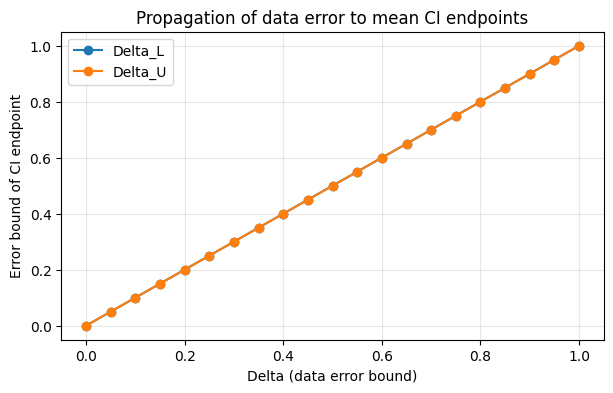

In [25]:
plt.figure(figsize=(7,4))
plt.plot(df_err_mean["Delta_data"], df_err_mean["Delta_L"], marker="o", label="Delta_L")
plt.plot(df_err_mean["Delta_data"], df_err_mean["Delta_U"], marker="o", label="Delta_U")
plt.xlabel("Delta (data error bound)")
plt.ylabel("Error bound of CI endpoint")
plt.title("Propagation of data error to mean CI endpoints")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Анализ пункта 4: распространение погрешности данных на границы ДИ для матожидания

Таблица соответствует теоретическому результату:

Если каждое наблюдение измерено с одинаковой абсолютной погрешностью $|\varepsilon_i|\le \Delta$,
то среднее изменяется не более чем на $\Delta$:
$$
|\bar x^{\text{obs}}-\bar x|
=
\left|\frac{1}{n}\sum_{i=1}^n \varepsilon_i\right|
\le
\frac{1}{n}\sum_{i=1}^n |\varepsilon_i|
\le \Delta.
$$

Доверительный интервал для матожидания имеет вид:
$$
[L,U]=[\bar x-c,\ \bar x+c],
$$
где $c$ не зависит от сдвига данных (при фиксированных $n,\alpha,\sigma$).

Следовательно,
$$
|L^{\text{obs}}-L|\le \Delta,\qquad |U^{\text{obs}}-U|\le \Delta,
$$
то есть предел погрешности обеих границ равен $\Delta$.

Это даёт линейную зависимость:
$$
\Delta_L(\Delta)=\Delta,\quad \Delta_U(\Delta)=\Delta,
$$
что и отражено в таблице.

# 5. Погрешность границ ДИ для квантилей при погрешности данных $\Delta$

При одинаковой абсолютной погрешности исходных данных $|\varepsilon_i|\le \Delta$:
$$
\Delta_L(\Delta)=\Delta,\quad \Delta_U(\Delta)=\Delta
$$
для доверительных интервалов, границы которых выражаются через порядковые статистики или их линейную интерполяцию.

In [26]:
delta_grid = np.linspace(0.0, 1.0, 21)

def make_err_table_for_p(p: float, delta_grid: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame({
        "p": p,
        "Delta_data": delta_grid,
        "Delta_L": delta_grid,
        "Delta_U": delta_grid,
    })

df_err_q = pd.concat(
    [
        make_err_table_for_p(0.5, delta_grid),
        make_err_table_for_p(0.01, delta_grid),
        make_err_table_for_p(0.99, delta_grid),
    ],
    ignore_index=True
)

df_err_q

,p,Delta_data,Delta_L,Delta_U
0,0.50,0.00,0.00,0.00
1,0.50,0.05,0.05,0.05
2,0.50,0.10,0.10,0.10
3,0.50,0.15,0.15,0.15
4,0.50,0.20,0.20,0.20
...,...,...,...,...
58,0.99,0.80,0.80,0.80
59,0.99,0.85,0.85,0.85
60,0.99,0.90,0.90,0.90
61,0.99,0.95,0.95,0.95


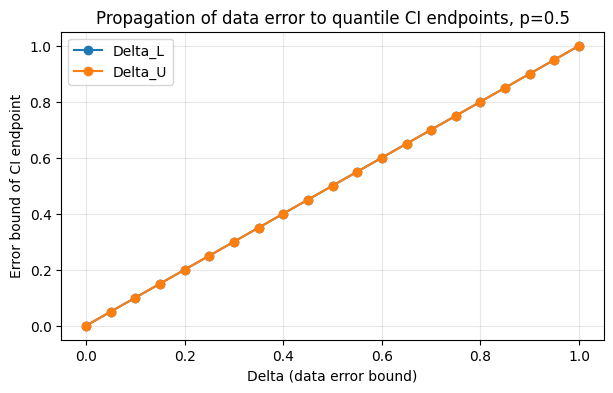

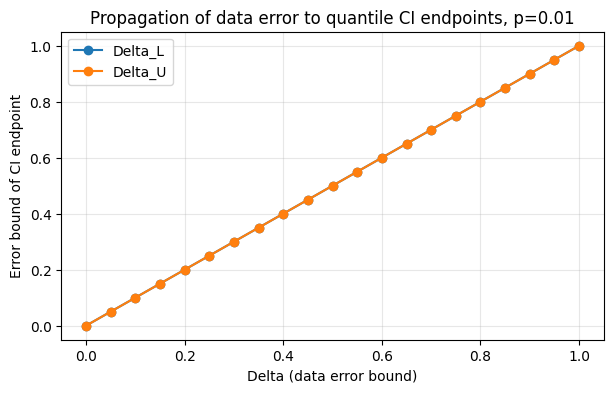

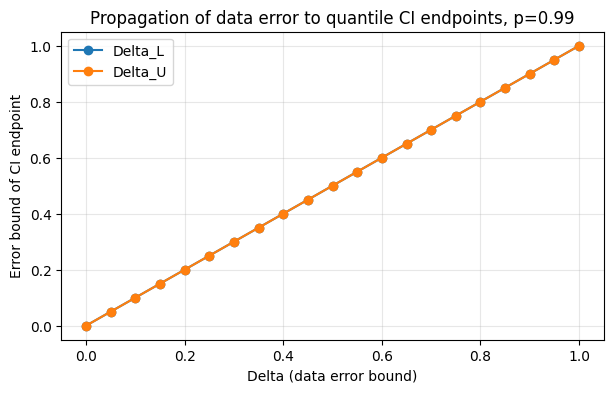

In [27]:
def plot_err_bounds(df: pd.DataFrame, p: float):
    sub = df[df["p"] == p]
    plt.figure(figsize=(7,4))
    plt.plot(sub["Delta_data"], sub["Delta_L"], marker="o", label="Delta_L")
    plt.plot(sub["Delta_data"], sub["Delta_U"], marker="o", label="Delta_U")
    plt.xlabel("Delta (data error bound)")
    plt.ylabel("Error bound of CI endpoint")
    plt.title(f"Propagation of data error to quantile CI endpoints, p={p}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_err_bounds(df_err_q, p=0.5)
plot_err_bounds(df_err_q, p=0.01)
plot_err_bounds(df_err_q, p=0.99)

## Анализ пункта 5: распространение погрешности данных на границы ДИ для медианы, 1% и 99% квантилей

Полученные графики и таблица показывают линейную зависимость:
$$
\Delta_L(\Delta)=\Delta,\qquad \Delta_U(\Delta)=\Delta
$$
для всех трёх уровней $p\in\{0.5,0.01,0.99\}$.

Это соответствует теоретическому утверждению об устойчивости выборочных квантилей к равномерной по $\ell_\infty$ погрешности данных.

### Обоснование
Пусть наблюдения искажены так, что
$$
|x_i^{\text{obs}}-x_i|\le \Delta,\quad i=1,\dots,n.
$$

Тогда после сортировки выполняется:
$$
|x^{\text{obs}}_{(k)}-x_{(k)}|\le \Delta,\quad k=1,\dots,n,
$$
поскольку перестановка не меняет верхнюю оценку покоординатного отклонения.

Следовательно, любая граница доверительного интервала, построенная как:
- порядковая статистика $x_{(k)}$, или
- линейная интерполяция $(1-\gamma)x_{(k)}+\gamma x_{(k+1)}$,

изменяется не более чем на $\Delta$.

Отсюда для левой и правой границы ДИ квантилей:
$$
|L^{\text{obs}}-L|\le \Delta,\qquad |U^{\text{obs}}-U|\le \Delta.
$$

### Итог пункта 5
Для медианы, 1% и 99% квантилей предел погрешности обеих границ ДИ совпадает с пределом погрешности исходных данных и не зависит от $p$:
$$
\Delta_L(\Delta)=\Delta_U(\Delta)=\Delta.
$$

# Финальные выводы по заданию (пункты 1–5)

1) Для дисперсии:
- chi-square (normal-theory) интервал корректен по покрытию только для нормального распределения;
- при ненормальности он может давать сильное перекрытие (равномерное) или сильное недокрытие (экспонента);
- асимптотический интервал по известным моментам $\mu_4$ в эксперименте дал покрытие близкое к 0.95 на всех трёх распределениях, но требует отсечения нижней границы на 0 из-за возможных отрицательных значений.

2) Для MAD:
- бутстрэп-интервалы дают покрытие, приближающееся к 0.95 при росте $n$;
- percentile обычно более устойчив по покрытию на асимметричных распределениях.

3) Достаточный объём выборки для ДИ среднего:
$$
n(\Delta)=\left\lceil \left(\frac{z_{1-\alpha/2}\sigma}{\Delta}\right)^2 \right\rceil,
$$
при $\sigma=1$ даёт квадратичный рост $n$ при уменьшении $\Delta$.

4) Достаточный объём выборки для ДИ квантилей:
$$
n(\Delta)=\left\lceil
\frac{z_{1-\alpha/2}^2\,p(1-p)}
{\Delta^2\, f(q_p)^2}
\right\rceil,
$$
и различия между распределениями полностью определяются величиной $f(q_p)$:
в хвостах при малой плотности требуемый $n$ становится очень большим.

5) Распространение погрешности измерений:
при одинаковой абсолютной погрешности данных $|\varepsilon_i|\le \Delta$ предел погрешности обеих границ ДИ для среднего и для квантилей равен $\Delta$:
$$
\Delta_L(\Delta)=\Delta_U(\Delta)=\Delta.
$$
